In [1]:
import Flux.Data: DataLoader
import PyPlot: figure, plot, xlabel, ylabel, title, ylim, grid, legend, tight_layout, show

In [2]:
include("src/TransformSGLD.jl")

update! (generic function with 3 methods)

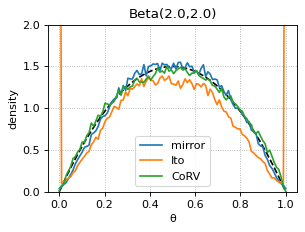

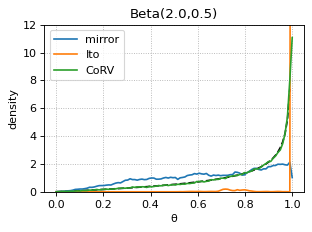

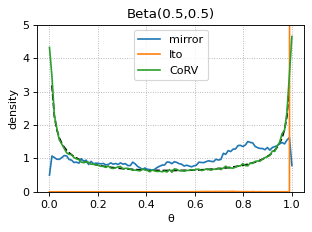

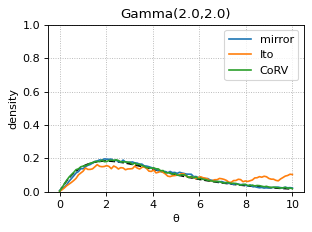

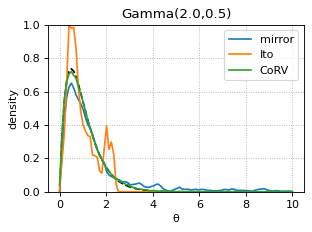

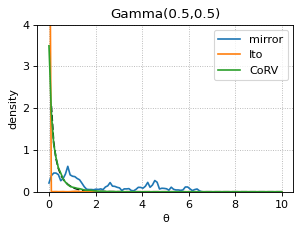

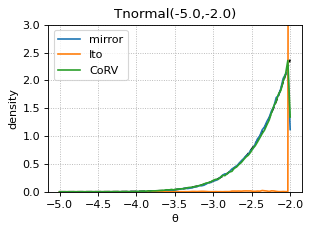

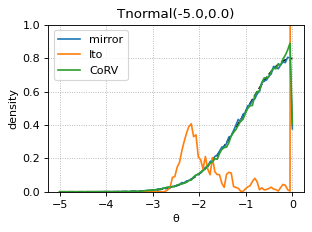

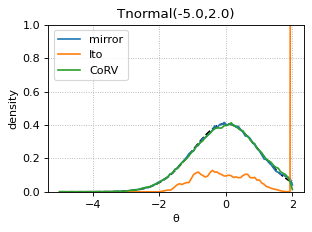

In [5]:
dists = [
    BetaDist(2.0, 2.0),
    BetaDist(2.0, 0.5),
    BetaDist(0.5, 0.5),
    GammaDist(2.0, 2.0),
    GammaDist(2.0, 0.5),
    GammaDist(0.5, 0.5),
    TnormalDist(-5.0, -2.0),
    TnormalDist(-5.0,  0.0),
    TnormalDist(-5.0,  2.0)
]

samplers = [mirrorSGLD, ItoSGLD, CoRVSGLD]

# sampling configuration
n_sample = 100000
data = DataLoader(1:n_sample, batchsize=1, shuffle=true, partial=false) # dummy data
rseed = 1234

# hyperparameter tuning
n_trial = 100
lr_range = exp10.(LinRange(-5,0,1000))

# choose distribution
for dist in dists
    # choose transform
    trans = any(isinf.(dist.domain)) ?  SoftplusTransform(dist.domain...) : SigmoidTransform(dist.domain...)
    
    results = []
    # choose sampler
    for sampler in samplers
        # find best learning rate using Gaussian Process
        best_lr = optimize_lr_for_pdf(n_trial, lr_range, dist, sampler, trans, data, rseed=rseed)
        # store sample
        seed!(rseed)
        samples = sample(dist, sampler(best_lr), trans, data)
        push!(results, samples)
    end
    
    # plot histogram
    xs = evalpoints(dist.domain)
    figure(figsize=(4,3), dpi=80)
    plot(xs, dist.pdf.(xs), "--", color="black")
    plot(xs, density(results[1], xs), label="mirror")
    plot(xs, density(results[2], xs), label="Ito")
    plot(xs, density(results[3], xs), label="CoRV")
    ylim(ymin=0, ymax=ceil(maximum(density(results[3], xs))))
    xlabel("θ"); ylabel("density"); title(dist.name); grid(linestyle="dotted"); legend()
    tight_layout(); show()
end